This part will be the most

sentiment-wise
topic-wise

semantic difference

Words polarized ?
Posts polarized ?
Author polarized ? 


In [1]:
import re
import datetime
import itertools
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pymongo import MongoClient

import pyLDAvis
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from pyLDAvis import gensim
from scipy.spatial import distance

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))
sw.update(stopwords.words("english"))

Let's load the `doc2vec` model that we have trained.

In [2]:
import warnings
warnings.simplefilter('ignore')
    
from gensim import models
model = models.Doc2Vec.load("doc2vec_dbow_d100_n5_w15_mc5_s1e_05_t6.model")

Note that in `gensim`'s `doc2vec` model we can obtain *both* the document embedding and word embedding. For example,

1. The vector of document with tag `tag`: `model.docvecs[tag]`
2. The vector of word `word`: `model[word]`

We can do some quick checks to make sure the model was trained properly. We'll call the `most_similar()` function and check if the output list of words are semantically similar to the input word.

In [3]:
model.most_similar("race")

[(u'racial', 0.825962245464325),
 (u'ethnicity', 0.810067355632782),
 (u'races', 0.802207887172699),
 (u'ethnic', 0.7495372295379639),
 (u'color', 0.7449743151664734),
 (u'black', 0.7331588268280029),
 (u'racism', 0.7247092723846436),
 (u'white', 0.7186124920845032),
 (u'whites', 0.7181856036186218),
 (u'minorities', 0.7073538303375244)]

In [4]:
model.most_similar("money")

[(u'cash', 0.8195253610610962),
 (u'paying', 0.7856954336166382),
 (u'dollars', 0.7691073417663574),
 (u'fund', 0.7582569122314453),
 (u'funds', 0.7561745047569275),
 (u'paid', 0.7487441301345825),
 (u'pay', 0.7244888544082642),
 (u'spendable', 0.724132776260376),
 (u'pays', 0.7186272740364075),
 (u'profitable', 0.713617742061615)]

## Identify the differentially over-represented words

First, we would like to know what words are spoken more often in **r/MensRights** than in **r/Feminism**, and vice versa. As we did previously, we'll compute the log-odds ratio (zscore) that measures the extent to which a word is over represented in one corpus with resepct to another corpus.

In [5]:
# Helper function for computing zscore (log-odds ratio)
def zscore(word,
           counter_i, n_i,
           counter_j, n_j,
           counter_0, n_0, log=np.log):
    """
    Input: `word`: the word that is present in both 'corpus_i' and 'corpus_j'

           `counter_i`: counter of words in 'corpus_i'
           `n_i`: total number of words in 'corpus_i'
           
           `counter_j`: counter of words in 'corpus_j'
           `n_j`: total number of words in 'corpus_j'
           
           `counter_0`: counter of words in the background corpus
           `n_0`: total number of words in the background corpus
           
    Function for computing the log-odds ratio. The LARGER the zscore, the MORE overrepresented
    the word `word` is in 'corpus_i' than in 'corpus_j'
    """
    
    y_i = np.float(counter_i[word])
    y_j = np.float(counter_j[word])
    a_w = np.float(counter_0[word])

    ratio_i = (y_i + a_w) / (n_i + n_0 - y_i - a_w)
    ratio_j = (y_j + a_w) / (n_j + n_0 - y_j - a_w)

    if ratio_i < 0.:
        raise ValueError("ratio_i is negative: %f\n" % ratio_i)
    if ratio_j < 0.:
        raise ValueError("ratio_j is negative: %f\n" % ratio_j)

    logratio = log(ratio_i) - log(ratio_j)

    try:
        var_logratio = 1. / (y_i + a_w) + 1. / (y_j + a_w)
    except ZeroDivisionError as inst:
        print inst

    try:
        z = logratio / np.sqrt(var_logratio)
    except Exception as inst:
        print inst

    return z

# Helper function that determines if a word is a valid word (i.e. \w+) and not belong to the stop-words
def valid_word(word):
    return re.match(r"[a-z]+$", word) is not None and word not in sw

# Helper function that retrieves the word vector from the trained doc2vec model
def word_vec(row):
    return pd.Series([model[row["word"]]])

Build the counter (`men_counter`, `fem_counter`, and `background_counter`) for the words that are present in the corpus (i.e. posts must have at least 30 tokens) used to train the `doc2vec` model:

In [6]:
men_counter = Counter()
fem_counter = Counter()

for post in db["MensRights"].find({}, {"tokens": 1, "_id": 0}):
    text = post["tokens"].split()
    # Use the same filter when we trained the doc2vec model: keep only posts with >= 30 words
    if len(text) >= 30:
        men_counter.update(text)

for post in db["Feminism"].find({}, {"tokens": 1, "_id": 0}):
    text = post["tokens"].split()
    if len(text) >= 30:
        fem_counter.update(text)       
        
background_counter = Counter()
background_counter.update(men_counter)
background_counter.update(fem_counter)  

Next
1. Compute the sizes of the corpora (`n_i`, `n_j`, and `n_0`)
2. Find the words that are present in both `men_counter` and `fem_counter`
3. Compute the zscores

In [7]:
n_i = sum(men_counter.values())
n_j = sum(fem_counter.values())
n_0 = sum(background_counter.values())

common = set(men_counter.keys()) & set(fem_counter.keys())
common = list(common)

df = [(w, zscore(w,
                 counter_i=men_counter, n_i=n_i,
                 counter_j=fem_counter, n_j=n_j,
                 counter_0=background_counter, n_0=n_0)) for w in common]

df = pd.DataFrame(df, columns=["word", "zscore"])
df = df.sort_values(by="zscore")

# Keep only the valid words
print df.shape
df = df[df["word"].map(valid_word)]
print df.shape

(81684, 2)
(63226, 2)


In [8]:
df[:3]

,word,zscore
77411,characters,-30.226672
14138,rfeminism,-22.565061
25508,character,-22.168835


In [9]:
df[-3:]

,word,zscore
54229,circumcision,17.841694
20800,child,22.296098
10037,men,22.930491


Now we have sorted the words in ascending order of zscores in `df`. Note that words with *low* zscores are overrepresented in **r/Feminism**, and those with *high* zscores are overrepresented in **r/MensRights**. We pick the 500 words with largest absolute values of zscores, and find their word vectors from the trained `doc2vec` model:

In [10]:
men_specific_word = df[["word"]][-500:]
fem_specific_word = df[["word"]][:500]

men_specific_word["vec"] = men_specific_word.apply(lambda row: word_vec(row), axis=1)
fem_specific_word["vec"] = fem_specific_word.apply(lambda row: word_vec(row), axis=1)

X_men_specific_word = np.array([v for v in men_specific_word["vec"]])
X_fem_specific_word = np.array([v for v in fem_specific_word["vec"]])

Note that when we trained the `doc2vec` model we specified the number of dimensionality to be 100 -- both document and words are represented by 100-D real-valued dense vectors.

`X_men_specific_word` and `X_fem_specific_word` contains the vectors of words overly represented in **r/MensRights** and **r/Feminism**, respectively.

In [11]:
X_men_specific_word.shape, X_fem_specific_word.shape

((500, 100), (500, 100))

### WordCloud of overrepresented words

Next we'll visualize the top 50 overly represented words in either subreddit to have some idea about how different they are.

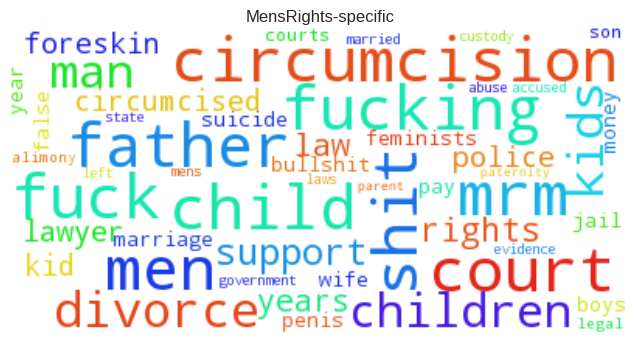

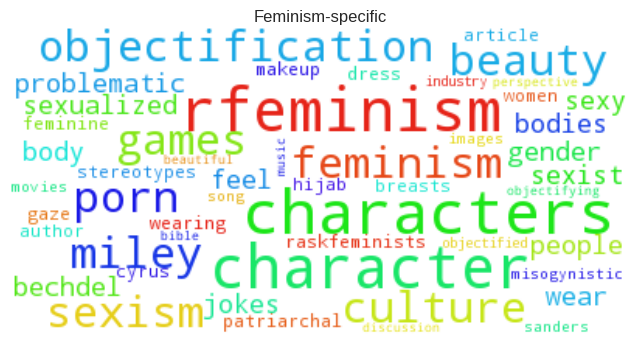

In [12]:
men = dict(df.iloc[-50:, :].values)
fem = dict(df.iloc[:50, :].values)

wc_men = WordCloud(max_font_size=40,
                   background_color='white').generate_from_frequencies((k, abs(men[k])) for k in men.keys())
wc_fem = WordCloud(max_font_size=40,
                   background_color='white').generate_from_frequencies((k, abs(fem[k])) for k in fem.keys())

plt.imshow(wc_men)
plt.title("MensRights-specific")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(wc_fem)
plt.title("Feminism-specific")
plt.xticks([])
plt.yticks([])
plt.show()

As we can see, words that are overly represented in **r/MensRights** and **r/Feminism** seem to be semantically different:

1. r/MensRights-overrepresented words are related to *law and legal*, *sex*, *family and marriage*, and *curse words*
2. r/Feminism-overrepresented words are related to *objectification*, *dressing and body parts*, *online discussion on reddit*, *sex*, and *jargons in ideologies*

### Visualize the embedding of overrepresented words

Remember that `doc2vec` model provides not only the embedding of *documents* but also the embedding of *words*. So we can visualize the overly represented *words* in 2D vector space using the dimensionality reduction technique t-SNE. This would enable us to understand how these overly represented words are semantically related with each other.

In [13]:
X_men_specific_word.shape, X_fem_specific_word.shape

((500, 100), (500, 100))

In [14]:
X = np.r_[X_men_specific_word, X_fem_specific_word]
tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [15]:
X.shape, X_tsne.shape

((1000, 100), (1000, 2))

In [16]:
X_men_specific_word_tsne = X_tsne[:500, :]
X_fem_specific_word_tsne = X_tsne[-500:, :]

Plot the embeddings in 2D space that are color-labeled:  <span style="color:red">**r/MensRights**</span> and <span style="color:blue">**r/Feminism**</span>

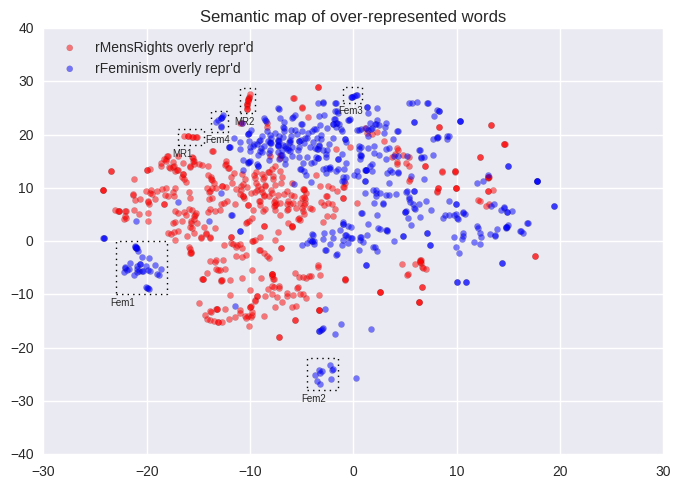

In [17]:
import matplotlib.patches as patches

plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="r", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[-500:, 0], X_tsne[-500:, 1], c="b", alpha=0.5, linewidths=0.1)
plt.legend(["rMensRights overly repr'd", "rFeminism overly repr'd"], loc=2)

ax = plt.gca()

for coordinate, width, height, tag in [((-17, 18), 2.5, 3, "MR1"), ((-11, 24), 1.5, 4.8, "MR2")]:
    rect = patches.Rectangle(coordinate, width, height, linewidth=1, edgecolor='k', facecolor='none', linestyle="dotted")
    ax.add_patch(rect)
    plt.text(coordinate[0] - 0.5, coordinate[1] - 2, tag, fontsize=7.0)

for coordinate, width, height, tag in [((-23, -10), 5, 10, "Fem1"), ((-4.5, -28), 3, 6, "Fem2"), ((-1, 26), 1.8, 3, "Fem3"), ((-13.8, 20.5), 1.7, 4, "Fem4")]:
    rect = patches.Rectangle(coordinate, width, height, linewidth=1, edgecolor='k', facecolor='none', linestyle="dotted")
    ax.add_patch(rect)
    plt.text(coordinate[0] - 0.5, coordinate[1] - 2, tag, fontsize=7.0)
    
plt.title("Semantic map of over-represented words")    
plt.show()

Note that words overly represented in **r/MensRights** and in **r/Feminism** seem to occupy completely different spaces.

Also note that words embeddings form *clusters*. Here I manually picked some clusters and listed the words. As you can see, words that belong to the same cluster are *semantically* closely related and seem to form a coherent *topic*.

In [18]:
for coordinate, width, height, tag in [((-17, 18), 2.5, 3, "MR1"), ((-11, 24), 1.5, 4.8, "MR2")]:
    index = np.where((X_men_specific_word_tsne[:, 0] < coordinate[0] + width) &
                     (X_men_specific_word_tsne[:, 0] > coordinate[0]) &
                     (X_men_specific_word_tsne[:, 1] < coordinate[1] + height) &
                     (X_men_specific_word_tsne[:, 1] > coordinate[1]))[0]
    
    print tag
    print men_specific_word.iloc[index]["word"].values
    print     

MR1
[u'killing' u'deaths' u'died' u'killed' u'death' u'die' u'kill']

MR2
[u'students' u'colleges' u'universities' u'ix' u'student' u'campus'
 u'college' u'university' u'school' u'teachers' u'teacher']



In [19]:
for coordinate, width, height, tag in [((-23, -10), 5, 10, "Fem1"), ((-4.5, -28), 3, 6, "Fem2"), ((-1, 26), 1.8, 3, "Fem3"), ((-13.8, 20.5), 1.7, 4, "Fem4")]:
    index = np.where((X_fem_specific_word_tsne[:, 0] < coordinate[0] + width) &
                     (X_fem_specific_word_tsne[:, 0] > coordinate[0]) &
                     (X_fem_specific_word_tsne[:, 1] < coordinate[1] + height) &
                     (X_fem_specific_word_tsne[:, 1] > coordinate[1]))[0]

    print tag
    print fem_specific_word.iloc[index]["word"].values
    print 

Fem1
[u'wear' u'dress' u'makeup' u'wearing' u'hijab' u'clothing' u'hair'
 u'shaving' u'shave' u'bikini' u'clothes' u'costume' u'fashion' u'leggings'
 u'bra' u'heels' u'costumes' u'outfits' u'dressing' u'revealing' u'yoga'
 u'shaved' u'skirts' u'outfit' u'burqa' u'niqab' u'apparel' u'dressed'
 u'dresses' u'skirt' u'wore' u'hairy' u'armpit' u'hijabs' u'armpits']

Fem2
[u'ads' u'marketing' u'product' u'marketed' u'advertising' u'dove'
 u'magazines' u'runways' u'advertisements' u'ad']

Fem3
[u'jokes' u'tosh' u'joke' u'humor' u'comedians' u'comedy']

Fem4
[u'wnba' u'player' u'sports' u'athletes' u'sport' u'players'
 u'cheerleaders' u'volleyball']



## From polarized *words* to polarized *posts*

As we can see in the previous section, we have found evidence that the overly represented *words* in **r/MensRights** and **r/Feminism** appear to be semantically different. Next we'll follow up in the same direction by examining the *posts*: we'll focus on posts that received the highest scores (i.e. upvotes minus downvotes) in **r/MensRights** and **r/Feminism**, and see if they are semantically *polarized*.

Note that the word vectors and document vectors produced by `doc2vec` are in the same *semantic space*. So technically we can compare the semantic distance between a *doc* vector and a *word* vector. 

First, we'll sanity-check if the top scoring posts in **r/MensRights** are semantically more similar to words over-represented in **r/MensRights** than in **r/Feminism**; and similarly, if the top scoring posts in **r/Feminism** are semantically more similar to words over-represented in **r/Feminism** than in **r/MensRights**.

To make the *doc-to-word* semantic comparison easier, we'll simply reduce the set of 500 over-represented words in **r/MensRights** and **r/Feminism** (i.e. rows in `X_men_specific_word` and `X_fem_specific_word`) to their arithmetic mean (i.e. `X_men_specific_word_mean` and `X_fem_specific_word_mean`)

In [20]:
X_men_specific_word_mean = X_men_specific_word.mean(axis=0)
X_fem_specific_word_mean = X_fem_specific_word.mean(axis=0)

We'll retrieve the 500 top scoring posts in **r/MensRights** and **r/Feminism**. Then we'll find their document vectors from the `doc2vec` model we just trained, and visualize them (i.e. `X_men_top500_post` and `X_fem_top500_post`) together with the averages of the overly represented words (i.e. `X_men_specific_word_mean` and `X_fem_specific_word_mean`)  using t-SNE.

In [21]:
X_men_top500_post = []
X_fem_top500_post = []

# Sort all posts in descending order of the `score` (i.e. `upvotes` minus `downvotes`),
# and keep the 500 top-scoring posts with a mininum of 30 tokens
for post in db["MensRights"].find({}, {"score": 1, "tokens": 1, "_id": 1}).sort("score", pymongo.DESCENDING):
    text = post["tokens"].split()
    if len(text) >= 30:
        X_men_top500_post.append(model.docvecs[str(post["_id"])])
    if len(X_men_top500_post) >= 500:
        break
        
for post in db["Feminism"].find({}, {"score": 1, "tokens": 1, "_id": 1}).sort("score", pymongo.DESCENDING):
    text = post["tokens"].split()
    if len(text) >= 30:
        X_fem_top500_post.append(model.docvecs[str(post["_id"])])
    if len(X_fem_top500_post) >= 500:
        break
        
X_men_top500_post = np.array(X_men_top500_post)
X_fem_top500_post = np.array(X_fem_top500_post)

In [22]:
(X_men_top500_post.shape,
 X_fem_top500_post.shape,
 X_men_specific_word_mean.shape,
 X_fem_specific_word_mean.shape)

((500, 100), (500, 100), (100,), (100,))

Fit the t-SNE model on the document vectors and the centers of the word vectors:

In [23]:
X = np.r_[X_men_top500_post,
          X_men_specific_word_mean[np.newaxis, :],
          X_fem_specific_word_mean[np.newaxis, :],
          X_fem_top500_post,]

tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [24]:
X.shape, X_tsne.shape

((1002, 100), (1002, 2))

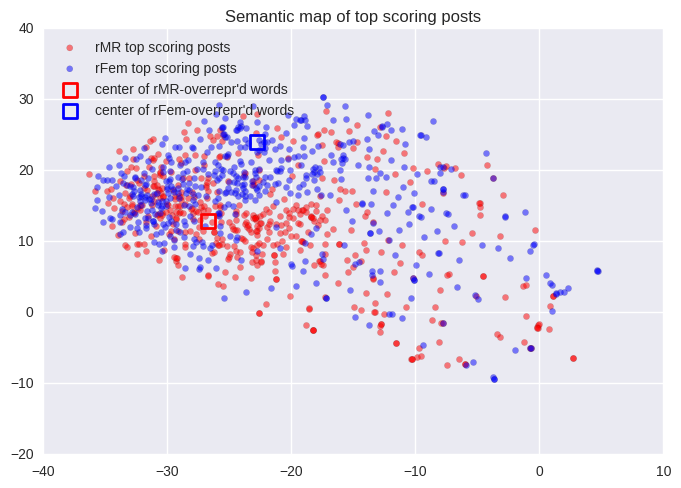

In [25]:
plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="r", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[-500:, 0], X_tsne[-500:, 1], c="b", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[500, 0], X_tsne[500, 1], linewidths=2, edgecolors="r", marker="s", facecolor="", s=100)
plt.scatter(X_tsne[501, 0], X_tsne[501, 1], linewidths=2, edgecolors="b", marker="s", facecolor="", s=100)
plt.legend(["rMR top scoring posts",
            "rFem top scoring posts",
            "center of rMR-overrepr'd words",
            "center of rFem-overrepr'd words"], loc=2)

plt.title("Semantic map of top scoring posts")
plt.show()

As we can see, the document embeddings of top scoring posts in **r/MensRights** and **r/Feminism** *still* occupy different space in this *semantic map* (though the contrast was not as conspicuous as the case for polarized words): the center of the vectors of r/MensRights-overrepresented words (<span style="color:red">red square</span>) are surrounded by more top scoring posts in **r/MensRights**; similarly, the center of the vectors of r/Feminism-overrepresented words (<span style="color:blue">blue square</span>) are surrounded by more top scoring posts in **r/Feminism**.

### Semantic distance between document vector and word vector

Next we'll *quantitatively* measure the semantic distance of each vector (<span style="color:red">red</span> dot) in `X_men_top500_post` (respectively `X_fem_top500_post`, <span style="color:blue">blue</span> dot) against the vector centers of the over-represented words (i.e. <span style="color:red">red</span> and <span style="color:blue">blue</span> squares).

For the distance measure, we'll consider cosine and euclidean distance.

In [26]:
# Helper function that computes the distance (cosine and euclidean) 
# between a list of vectors `vectors` and a target vector `center`
def cos_and_eucl_dist(vectors, center):
    cosine_dist = []
    euclidean_dist = []
    for vec in vectors:
        cosine_dist.append(distance.cosine(vec, center))
        euclidean_dist.append(np.linalg.norm(vec - center))
    return cosine_dist, euclidean_dist    

In [27]:
def plot_dist(cosine_dists, euclidean_dists, ymax, labels, colors=["r", "b"], linestyle=["-", "-"]):
    
    lines = len(cosine_dists)
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    for i in range(lines):
        sns.kdeplot(np.array(cosine_dists[i]), ax=ax1, c=colors[i], label=labels[i], linestyle=linestyle[i])
    for i in range(lines):
        ax1.vlines(np.array(cosine_dists[i]).mean(), 0, ymax[0], color=colors[i], linewidth=0.5, linestyle=linestyle[i])
        
    for i in range(lines):
        sns.kdeplot(np.array(euclidean_dists[i]), ax=ax2, c=colors[i], label=labels[i], linestyle=linestyle[i])
    for i in range(lines):
        ax2.vlines(np.array(euclidean_dists[i]).mean(), 0, ymax[1], color=colors[i], linewidth=0.5, linestyle=linestyle[i])
        
    ax1.set_xlabel("cosine distance")
    ax2.set_xlabel("Euclidean distance")
    ax1.set_ylabel("Density")
    ax2.set_ylabel("Density")

    ax1.legend(loc=9)
    ax2.legend(loc=9)
    f.set_figheight(3)
    f.set_figwidth(12)

In [28]:
cosine_men500__menspecific, euclidean_men500__menspecific = cos_and_eucl_dist(X_men_top500_post, X_men_specific_word_mean)
cosine_men500__femspecific, euclidean_men500__femspecific = cos_and_eucl_dist(X_men_top500_post, X_fem_specific_word_mean)

In [29]:
%matplotlib inline

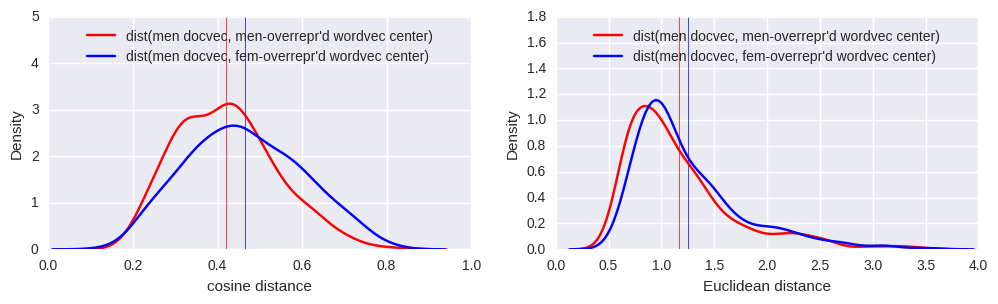

In [30]:
plot_dist([cosine_men500__menspecific, cosine_men500__femspecific],
          [euclidean_men500__menspecific, euclidean_men500__femspecific], [5, 1.8],
          labels=["dist(men docvec, men-overrepr'd wordvec center)",
                      "dist(men docvec, fem-overrepr'd wordvec center)"])

In [31]:
pd.Series([np.mean(cosine_men500__menspecific),
           np.mean(cosine_men500__femspecific),
           np.mean(euclidean_men500__menspecific),
           np.mean(euclidean_men500__femspecific)],
          index=["Avg(cosine_dist(RED dot, RED square))",
                 "Avg(cosine_dist(RED dot, BLUE square))",
                 "Avg(eucl_dist(RED dot, RED square))",
                 "Avg(eucl_dist(RED dot, BLUE square))"])

Avg(cosine_dist(RED dot, RED square))     0.420498
Avg(cosine_dist(RED dot, BLUE square))    0.464411
Avg(eucl_dist(RED dot, RED square))       1.170797
Avg(eucl_dist(RED dot, BLUE square))      1.252067
dtype: float64

In [32]:
cosine_fem500__menspecific, euclidean_fem500__menspecific = cos_and_eucl_dist(X_fem_top500_post, X_men_specific_word_mean)
cosine_fem500__femspecific, euclidean_fem500__femspecific = cos_and_eucl_dist(X_fem_top500_post, X_fem_specific_word_mean)

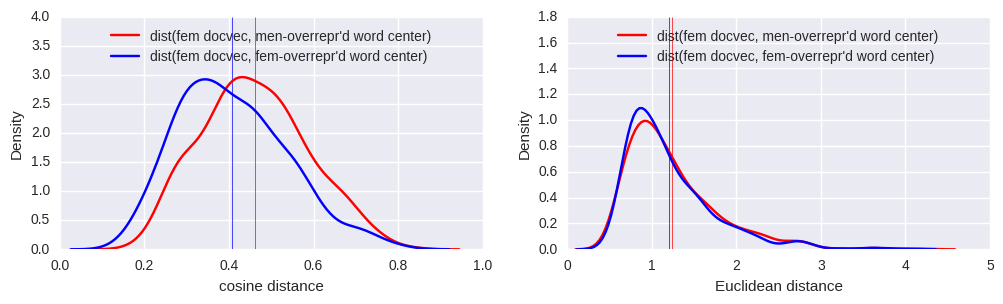

In [33]:
plot_dist([cosine_fem500__menspecific, cosine_fem500__femspecific],
          [euclidean_fem500__menspecific, euclidean_fem500__femspecific], [4.0, 1.8],
          labels=["dist(fem docvec, men-overrepr'd word center)",
                  "dist(fem docvec, fem-overrepr'd word center)"])

In [34]:
pd.Series([np.mean(cosine_fem500__menspecific),
           np.mean(cosine_fem500__femspecific),
           np.mean(euclidean_fem500__menspecific),
           np.mean(euclidean_fem500__femspecific)],
          index=["Avg(cosine_dist(BLUE dot, RED square))",
                 "Avg(cosine_dist(BLUE dot, BLUE square))",
                 "Avg(eucl_dist(BLUE dot, RED square))",
                 "Avg(eucl_dist(BLUE dot, BLUE square))"])

Avg(cosine_dist(BLUE dot, RED square))     0.460751
Avg(cosine_dist(BLUE dot, BLUE square))    0.407830
Avg(eucl_dist(BLUE dot, RED square))       1.238569
Avg(eucl_dist(BLUE dot, BLUE square))      1.206204
dtype: float64

In [35]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


As we can see the posts and words that are in the *same* subreddit seem to be more semantically related than when they are from *different* subreddit.

## Visualize authors in a semantic map

Now that we have some intuitive understanding about how polarized the distribution of the *words* and *posts* are, let's move on to *authors*. We'll build a profile for each author that semantically summarizes all his/her posts.

For each subreddit, we'll focus on two groups of authors

1. *Cross-posters* (polarized): those who posted in both **r/MensRights** and **r/Feminism**, and the posts made in one subreddit (aka *home subreddit*) received much higher scores than in the other subreddit (aka *away subreddit*): that is, the ***minimum*** score in the *home subreddit* must be greater than the ***maximum*** of the *away* subreddit
2. *Non-crossposters* (polarized): those who posted in exclusively in one subreddit, and their posts received the highest scores than other authors.


Note that for *cross-posters*, we separately consider the posts made in *home subreddit* and *away subreddit*.

In [36]:
# Helper function that returns the mean, min, max, and count of the scores of posts belonging to the same author

def agg_author(df):
    men_mean_score = df[df["subreddit"] == "MensRights"]["score"].mean()
    men_min_score = df[df["subreddit"] == "MensRights"]["score"].min()
    men_max_score = df[df["subreddit"] == "MensRights"]["score"].max()
    men_count = df[df["subreddit"] == "MensRights"]["score"].shape[0]
    
    fem_mean_score = df[df["subreddit"] == "Feminism"]["score"].mean()
    fem_min_score = df[df["subreddit"] == "Feminism"]["score"].min()
    fem_max_score = df[df["subreddit"] == "Feminism"]["score"].max()
    fem_count = df[df["subreddit"] == "Feminism"]["score"].shape[0]
    
    return pd.Series([men_mean_score, men_min_score, men_max_score, men_count,
                      fem_mean_score, fem_min_score, fem_max_score, fem_count],
                     index=["men_mean_score", "men_min_score", "men_max_score", "men_count",
                            "fem_mean_score", "fem_min_score", "fem_max_score", "fem_count"])

In [37]:
# Helper function that returns the authors in two groups from two subreddits
# `men_cp_polar`: polarized cross-posters in rMR
# `fem_cp_polar`: polarized cross-posters in rFem
# `men_only_polar`: polarized non-crossposters in rMR
# `fem_only_polar`: polarized non-crossposters in rFem

def polarized_authors(authors):
    men_author = pd.DataFrame(authors[authors["men_mean_score"].notnull()][["men_mean_score", "men_min_score",
                                                                            "men_max_score", "men_count"]])
    men_author = men_author.reset_index()
    
    fem_author = pd.DataFrame(authors[authors["fem_mean_score"].notnull()][["fem_mean_score", "fem_min_score",
                                                                            "fem_max_score", "fem_count"]])
    fem_author = fem_author.reset_index()
    
    print men_author.shape, fem_author.shape
    
    # `men_author`: users who posted >= 1 post in `r/MensRights`
    # `fem_author`: users who posted >= 1 post in `r/Feminism`
    # `df`: cross-posters
    df = men_author.merge(fem_author, left_on="author", right_on="author")
    
    # 1. Find polarized crossposters 
    # minimum of MR score > maxinum of Fem score
    men_cp_polar = pd.DataFrame(df[df["men_min_score"] > df["fem_max_score"]])
    men_cp_polar = men_cp_polar.sort_values("men_max_score", ascending=False)
    men_cp_polar = list(men_cp_polar["author"])
    
    # minimum of Fem score > maxinum of MR score
    fem_cp_polar = pd.DataFrame(df[df["fem_min_score"] > df["men_max_score"]])
    fem_cp_polar = fem_cp_polar.sort_values("fem_max_score", ascending=False)
    fem_cp_polar = list(fem_cp_polar["author"])
    
    # 2. Find polarized non-crossposters
    men_only_polar = set(men_author["author"]) - set(fem_author["author"])
    fem_only_polar = set(fem_author["author"]) - set(men_author["author"])
    
    men_only_polar = pd.DataFrame(men_author[men_author["author"].isin(men_only_polar)])
    fem_only_polar = pd.DataFrame(fem_author[fem_author["author"].isin(fem_only_polar)])

    men_only_polar = men_only_polar.sort_values("men_max_score", ascending=False)
    men_only_polar = list(men_only_polar["author"])

    fem_only_polar = fem_only_polar.sort_values("fem_max_score", ascending=False)
    fem_only_polar = list(fem_only_polar["author"])
        
    return men_cp_polar, fem_cp_polar, men_only_polar, fem_only_polar

Retrieve posts and keep only those with at least 30 tokens

In [38]:
men = pd.DataFrame(list(db["MensRights"].find({}, {"author": 1, "score": 1, "subreddit": 1,
                                                   "tokens": 1, "_id": 0})))
fem = pd.DataFrame(list(db["Feminism"].find({}, {"author": 1, "score": 1, "subreddit": 1,
                                                 "tokens": 1, "_id": 0})))
print men.shape, fem.shape

reddit_posts = pd.concat([men, fem], axis=0)
reddit_posts = reddit_posts[reddit_posts["tokens"].map(lambda x: len(x.split()) >= 30)]
reddit_posts = reddit_posts.drop("tokens", axis=1)

(2452716, 4) (213100, 4)


Create dataframe with author info (number of posts, mean, max, min of scores)

In [39]:
authors = reddit_posts.groupby("author").apply(agg_author)

Obtain the list of authors in different groups:

In [40]:
men_cp_polar, fem_cp_polar, men_only_polar, fem_only_polar = polarized_authors(authors)

(77375, 5) (22837, 5)


In [41]:
len(men_cp_polar), len(fem_cp_polar), len(men_only_polar), len(fem_only_polar)

(616, 684, 71461, 16923)

The authors in each group are ranked by the highest scores of their posts in descending order. Keep only top 500 authors.

In [42]:
men_cp_polar = men_cp_polar[:500]
fem_cp_polar = fem_cp_polar[:500]
men_only_polar = men_only_polar[:500]
fem_only_polar = fem_only_polar[:500]

#index1 = np.random.choice(len(men_only_polar), 500, replace=False)
#index2 = np.random.choice(len(fem_only_polar), 500, replace=False)

#men_only_polar = [men_only_polar[i] for i in index1]
#fem_only_polar = [fem_only_polar[i] for i in index2]

In [43]:
len(men_cp_polar), len(fem_cp_polar), len(men_only_polar), len(fem_only_polar)

(500, 500, 500, 500)

Define helper function `get_doc_vec_of_author` that computes the average of the document embedding over the posts made by a given `author` in a given `subreddit`

In [44]:
def get_doc_vec_of_author(author, subreddit):
    """
        Given `author` and `subreddit`, retrieve the doc vectors for all the posts made by 
        `author` in `subreddit` and return the average of the doc vectors
    """
    post_by_author = list(db[subreddit].find({"author": author}, {"score": 1, "_id": 1}))
    post_by_author = sorted(post_by_author, key=lambda post: -post["score"])

    score = []
    vec = []
    for post in post_by_author:
        if str(post["_id"]) in model.docvecs:
            score.append(post["score"])
            vec.append(model.docvecs[str(post["_id"])])
    
    support = len(score)
    score = np.array(score)
    vec = np.array(vec)
    return author, score.mean(), vec.mean(axis=0), support


Create profile information for each author: author ID, average score, author vector (average of document vectors of author'posts)

In [45]:
men_cp_polar_home = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "MensRights"), men_cp_polar),
                            columns=["author", "score", "vec", "support"])
fem_cp_polar_home = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "Feminism"), fem_cp_polar),
                            columns=["author", "score", "vec", "support"])

men_cp_polar_away = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "Feminism"), men_cp_polar),
                            columns=["author", "score", "vec", "support"])
fem_cp_polar_away = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "MensRights"), fem_cp_polar),
                            columns=["author", "score", "vec", "support"])

men_only_polar = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "MensRights"), men_only_polar),
                              columns=["author", "score", "vec", "support"])
fem_only_polar = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, "Feminism"), fem_only_polar),
                              columns=["author", "score", "vec", "support"])

In [46]:
men_cp_polar_home[:3]

,author,score,vec,support
0,AmerikanInfidel,293.5,"[0.00772101, -0.165015, -0.142764, -0.113977, ...",2
1,Ded0099,244.0,"[-0.062615, -0.148856, -0.138062, -0.181073, -...",2
2,PaddyRamoutar,127.5,"[0.0460412, -0.0353461, -0.148806, -0.0862709,...",2


In [47]:
fem_cp_polar_home[:3]

,author,score,vec,support
0,anUnkindness,63.714286,"[-0.0495606, -0.0548191, -0.0853542, -0.054466...",7
1,ArmedPigeon,33.666667,"[0.0314468, -0.0340486, 0.0612358, -0.00247688...",3
2,ducky-box,45.500000,"[-0.0439423, -0.0851742, -0.0126492, -0.058220...",2


In [48]:
men_cp_polar_away[:3]

,author,score,vec,support
0,AmerikanInfidel,-2.5,"[0.00837612, -0.175384, -0.173881, -0.0819796,...",2
1,Ded0099,1.0,"[-0.144676, -0.19054, -0.0413785, -0.121722, 0...",1
2,PaddyRamoutar,6.0,"[0.00157958, -0.125526, 0.08833, -0.0415175, 0...",1


In [49]:
fem_cp_polar_away[:3]

,author,score,vec,support
0,anUnkindness,1.0,"[0.0572927, -0.145726, -0.139567, -0.0394151, ...",1
1,ArmedPigeon,1.0,"[0.00451042, 0.0510831, 0.283433, -0.150591, 0...",1
2,ducky-box,1.0,"[0.0246351, -0.153648, -0.142939, -0.0801617, ...",2


In [50]:
men_only_polar[:3]

,author,score,vec,support
0,suicidalgod,307.625000,"[0.003706, -0.131141, -0.0573976, -0.14143, 0....",8
1,PuckyMacpuckpants,792.666667,"[-0.0212194, -0.085548, -0.094925, -0.0740819,...",3
2,DavidByron2,5.146924,"[-0.00610554, -0.0875204, -0.109632, -0.086983...",6323


In [51]:
fem_only_polar[:3]

,author,score,vec,support
0,Readvoter,42.625,"[-0.083607, -0.129222, -0.203358, -0.0601361, ...",8
1,its_all_too_much,96.000,"[-0.0148346, -0.0385529, -0.000309706, -0.1989...",3
2,psychologyst,61.400,"[0.13721, -0.0726363, -0.168473, 0.0255857, 0....",5


In [52]:
men_cp_polar_home = men_cp_polar_home[men_cp_polar_home["score"].notnull()]
fem_cp_polar_home = fem_cp_polar_home[fem_cp_polar_home["score"].notnull()]

men_cp_polar_away = men_cp_polar_away[men_cp_polar_away["score"].notnull()]
fem_cp_polar_away = fem_cp_polar_away[fem_cp_polar_away["score"].notnull()]

men_only_polar = men_only_polar[men_only_polar["score"].notnull()]
fem_only_polar = fem_only_polar[fem_only_polar["score"].notnull()]

In [53]:
(men_cp_polar_home.shape, fem_cp_polar_home.shape,
 men_cp_polar_away.shape, fem_cp_polar_away.shape,
 men_only_polar.shape, fem_only_polar.shape)

((500, 4), (500, 4), (500, 4), (500, 4), (500, 4), (500, 4))

Stack the author vectors in Numpy 2-D array (500, 100)

In [54]:
X_men_cp_polar_home = np.array([v for v in men_cp_polar_home["vec"]])
X_fem_cp_polar_home = np.array([v for v in fem_cp_polar_home["vec"]])

X_men_cp_polar_away = np.array([v for v in men_cp_polar_away["vec"]])
X_fem_cp_polar_away = np.array([v for v in fem_cp_polar_away["vec"]])

X_men_only_polar = np.array([v for v in men_only_polar["vec"]])
X_fem_only_polar = np.array([v for v in fem_only_polar["vec"]])

In [55]:
(X_men_cp_polar_home.shape, X_fem_cp_polar_home.shape,
 X_men_cp_polar_away.shape, X_fem_cp_polar_away.shape,
 X_men_only_polar.shape, X_fem_only_polar.shape)

((500, 100), (500, 100), (500, 100), (500, 100), (500, 100), (500, 100))

Fit the t-SNE model using all the data plus the averages of subreddit-specific overly represented words (i.e. X_men_specific_word_mean and X_fem_specific_word_mean)

In [56]:
X = np.r_[X_men_cp_polar_home,
          X_fem_cp_polar_home,
          X_men_cp_polar_away,
          X_fem_cp_polar_away,
          X_men_only_polar,
          X_fem_only_polar,
          X_men_specific_word_mean[np.newaxis, :],
          X_fem_specific_word_mean[np.newaxis, :]]

tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [57]:
X.shape, X_tsne.shape

((3002, 100), (3002, 2))

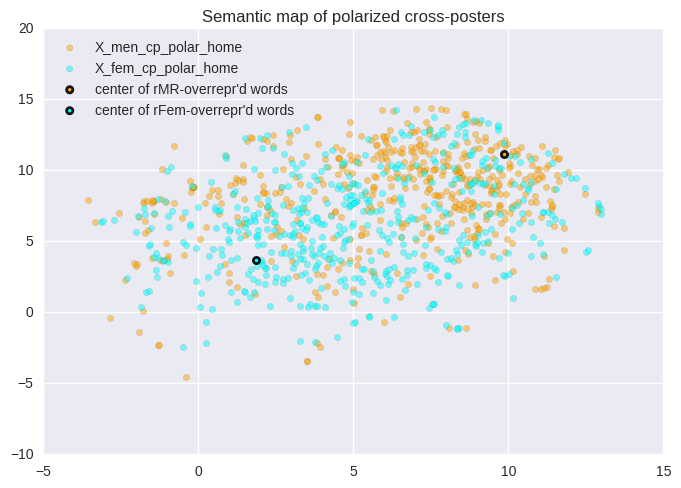

In [58]:
plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[500:1000, 0], X_tsne[500:1000, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2)
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2)
plt.legend(["X_men_cp_polar_home",
            "X_fem_cp_polar_home",
            "center of rMR-overrepr'd words",
            "center of rFem-overrepr'd words"], loc=2)
plt.title("Semantic map of polarized cross-posters")
plt.show()

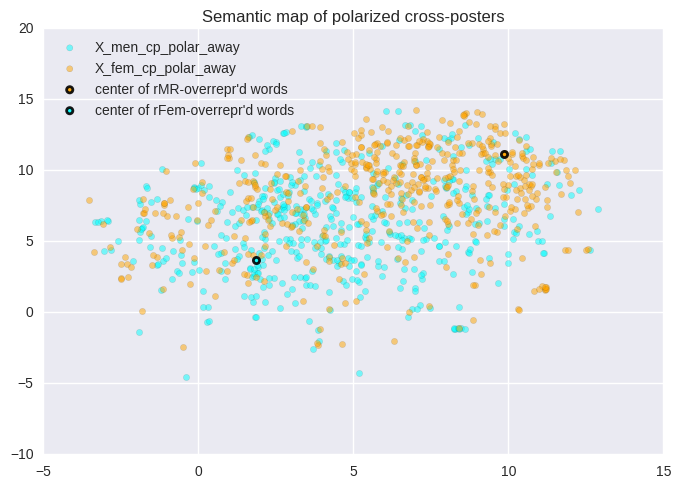

In [59]:
plt.scatter(X_tsne[1000:1500, 0], X_tsne[1000:1500, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[1500:2000, 0], X_tsne[1500:2000, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2)
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2)
plt.legend(["X_men_cp_polar_away",
            "X_fem_cp_polar_away",
            "center of rMR-overrepr'd words",
            "center of rFem-overrepr'd words"], loc=2)
plt.title("Semantic map of polarized cross-posters")
plt.show()

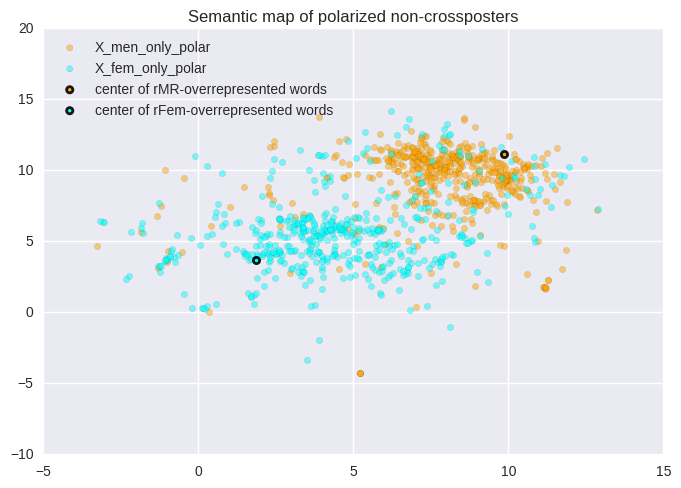

In [60]:
plt.scatter(X_tsne[2000:2500, 0], X_tsne[2000:2500, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[2500:3000, 0], X_tsne[2500:3000, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2)
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2)
plt.legend(["X_men_only_polar",
            "X_fem_only_polar",
            "center of rMR-overrepresented words",
            "center of rFem-overrepresented words"], loc=2)
plt.title("Semantic map of polarized non-crossposters")
plt.show()

In [64]:
cosine_men_cp_polar_home, euclidean_men_cp_polar_home = cos_and_eucl_dist(X_men_cp_polar_home, X_men_specific_word_mean)
cosine_fem_cp_polar_away, euclidean_fem_cp_polar_away = cos_and_eucl_dist(X_fem_cp_polar_away, X_men_specific_word_mean)
cosine_men_only_polar, euclidean_men_only_polar = cos_and_eucl_dist(X_men_only_polar, X_men_specific_word_mean)

In [65]:
%matplotlib inline

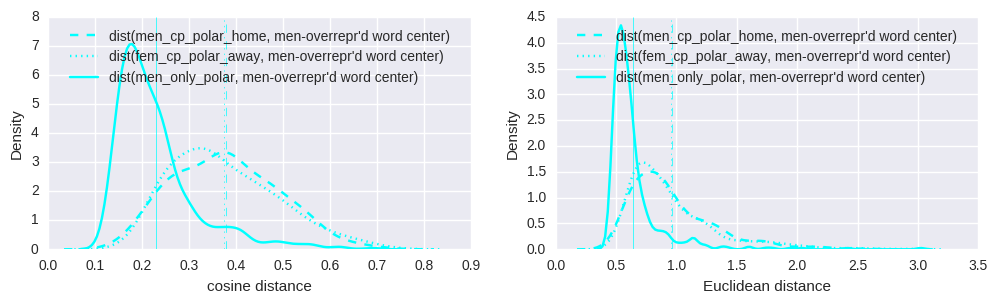

In [66]:
plot_dist([cosine_men_cp_polar_home, cosine_fem_cp_polar_away, cosine_men_only_polar],
          [euclidean_men_cp_polar_home, euclidean_fem_cp_polar_away, euclidean_men_only_polar],
          [8, 4.5],
          colors=["cyan", "cyan", "cyan"],
          linestyle=["dashed", "dotted", "-"],
          labels=["dist(men_cp_polar_home, men-overrepr'd word center)",
                  "dist(fem_cp_polar_away, men-overrepr'd word center)",
                  "dist(men_only_polar, men-overrepr'd word center)"])

In [67]:
[np.mean(cosine_men_cp_polar_home),
 np.mean(cosine_fem_cp_polar_away),
 np.mean(cosine_men_only_polar),
 np.mean(euclidean_men_cp_polar_home),
 np.mean(euclidean_fem_cp_polar_away),
 np.mean(euclidean_men_only_polar)]

[0.37791706327809244,
 0.3748063392798186,
 0.22887929770904283,
 0.96143395,
 0.95721281,
 0.64336509]

In [69]:
cosine_fem_cp_polar_home, euclidean_fem_cp_polar_home = cos_and_eucl_dist(X_fem_cp_polar_home, X_fem_specific_word_mean)
cosine_men_cp_polar_away, euclidean_men_cp_polar_away = cos_and_eucl_dist(X_men_cp_polar_away, X_fem_specific_word_mean)
cosine_fem_only_polar, euclidean_fem_only_polar = cos_and_eucl_dist(X_fem_only_polar, X_fem_specific_word_mean)

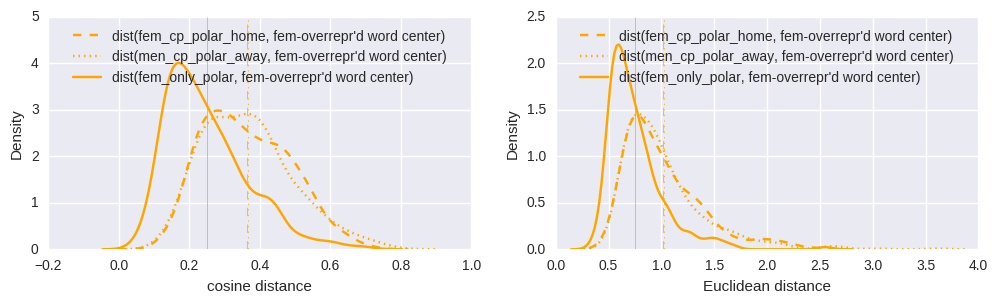

In [71]:
plot_dist([cosine_fem_cp_polar_home, cosine_men_cp_polar_away, cosine_fem_only_polar],
          [euclidean_fem_cp_polar_home, euclidean_men_cp_polar_away, euclidean_fem_only_polar],
          [5., 2.5],
          colors=["orange", "orange", "orange"],
          linestyle=["dashed", "dotted", "-"],
          labels=["dist(fem_cp_polar_home, fem-overrepr'd word center)",
                  "dist(men_cp_polar_away, fem-overrepr'd word center)",
                  "dist(fem_only_polar, fem-overrepr'd word center)"])

In [72]:
[np.mean(cosine_fem_cp_polar_home),
 np.mean(cosine_men_cp_polar_away),
 np.mean(cosine_fem_only_polar),
 np.mean(euclidean_fem_cp_polar_home),
 np.mean(euclidean_men_cp_polar_away),
 np.mean(euclidean_fem_only_polar)]

[0.36323404759664618,
 0.36528321419533072,
 0.24946369176127542,
 1.0180011,
 1.0201826,
 0.75308973]

In [73]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


diffusive

In [74]:
men_posts = pd.DataFrame(list(db["MensRights"].find({}, {"link_id": 1, "author": 1, "_id": 0})))
fem_posts = pd.DataFrame(list(db["Feminism"].find({}, {"link_id": 1, "author": 1, "_id": 0})))

In [75]:
men_by_author = men_posts.groupby("author").apply(lambda df: df["link_id"].unique())
fem_by_author = fem_posts.groupby("author").apply(lambda df: df["link_id"].unique())

In [76]:
men_by_thread = men_posts.groupby("link_id").apply(lambda df: df["author"].unique())
fem_by_thread = fem_posts.groupby("link_id").apply(lambda df: df["author"].unique())

In [80]:
def author_dist_by_common_thread(author_df, thread_df, dist_measure):
    """
    Input:
        -- author_df: `men_cp_polar`, `fem_cp_polar`, `men_only_polar`, `fem_only_polar`
        -- thread_df: `men_by_thread`, `fem_by_thread`
        -- dist_measure: "euclidean", "cosine"
    """
    
    out_df = np.empty((500 * 499 / 2, 2))
    c = 0
    for i in range(499):
        for j in range(i + 1, 500):
            a1 = author_df["author"].iat[i]
            a2 = author_df["author"].iat[j]
            out_df[c, 0] = len(set(thread_df[a1]) & set(thread_df[a2]))
            if dist_measure == "euclidean":
                out_df[c, 1] = np.linalg.norm(author_df["vec"].iat[i] - author_df["vec"].iat[j])
            else:
                out_df[c, 1] = distance.cosine(author_df["vec"].iat[i], author_df["vec"].iat[j])
            c += 1    
    
    out_df = pd.DataFrame(out_df)
    out_df.columns = ["count", "dist"]
    out_df = pd.concat([out_df["dist"].groupby(out_df["count"]).mean(),
                        out_df["dist"].groupby(out_df["count"]).count()], axis=1)
    out_df.columns = ["mean", "support"]
    out_df = out_df[["mean"]]
    return out_df

In [81]:
men_only_polar_trend = author_dist_by_common_thread(men_only_polar, men_by_author, "euclidean")
fem_only_polar_trend = author_dist_by_common_thread(fem_only_polar, fem_by_author, "euclidean")

In [82]:
df = pd.concat([men_only_polar_trend, fem_only_polar_trend], axis=1)
df.columns = ["men_only_polar", "fem_only_polar"]

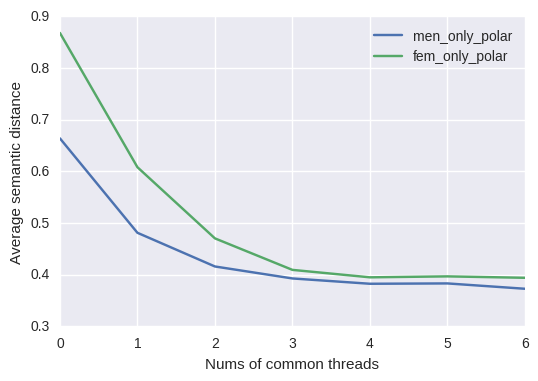

In [83]:
df[:6].plot()
plt.xlabel("Nums of common threads")
plt.ylabel("Average semantic distance")
plt.show()

In [80]:
from sklearn.neighbors import NearestNeighbors
nn_men_cp_polar = NearestNeighbors(n_neighbors=1).fit(X_men_cp_polar)
nn_fem_cp_polar = NearestNeighbors(n_neighbors=1).fit(X_fem_cp_polar)


In [81]:
def find_nearest_author(vec, nn, df):
    author_index = nn.kneighbors(X=[vec], n_neighbors=1, return_distance=False)[0][0]
    nn_author = df["author"].iat[author_index]
    return nn_author

In [82]:
def find_nearest_distance(vec, nn):
    distance = nn.kneighbors(X=[vec], n_neighbors=1, return_distance=True)[0][0][0]
    return distance

In [83]:
men_cp_polar["away_nn_author"] = men_cp_polar["vec"].map(lambda x: find_nearest_author(x,
                                                                                       nn_fem_cp_polar,
                                                                                       fem_cp_polar))

men_cp_polar["away_nn_dist"] = men_cp_polar["vec"].map(lambda x: find_nearest_distance(x, 
                                                                                       nn_fem_cp_polar))

In [84]:
fem_cp_polar["away_nn_author"] = fem_cp_polar["vec"].map(lambda x: find_nearest_author(x,
                                                                                       nn_men_cp_polar,
                                                                                       men_cp_polar))

fem_cp_polar["away_nn_dist"] = fem_cp_polar["vec"].map(lambda x: find_nearest_distance(x, 
                                                                                       nn_men_cp_polar))

In [105]:
men_cp_polar[:3]

,author,score,vec,away_nn_author,away_nn_dist
0,AmerikanInfidel,293.5,"[0.00772101, -0.165015, -0.142764, -0.113977, ...",crazygoalie2002,0.651382
1,Ded0099,244.0,"[-0.062615, -0.148856, -0.138062, -0.181073, -...",Altherd,0.561905
2,PaddyRamoutar,127.5,"[0.0460412, -0.0353461, -0.148806, -0.0862709,...",alvaspiral,0.545933


In [106]:
fem_cp_polar[:3]

,author,score,vec,away_nn_author,away_nn_dist
0,anUnkindness,63.714286,"[-0.0495606, -0.0548191, -0.0853542, -0.054466...",Spyder001,0.385881
1,ArmedPigeon,33.666667,"[0.0314468, -0.0340486, 0.0612358, -0.00247688...",on_the_redpill,0.951454
2,ducky-box,45.500000,"[-0.0439423, -0.0851742, -0.0126492, -0.058220...",BrazilianRider,0.525729


In [107]:
df = pd.concat([men_cp_polar, fem_cp_polar], axis=0)
df = df.reset_index(drop=True)

In [108]:
df[:3]

,author,score,vec,away_nn_author,away_nn_dist
0,AmerikanInfidel,293.5,"[0.00772101, -0.165015, -0.142764, -0.113977, ...",crazygoalie2002,0.651382
1,Ded0099,244.0,"[-0.062615, -0.148856, -0.138062, -0.181073, -...",Altherd,0.561905
2,PaddyRamoutar,127.5,"[0.0460412, -0.0353461, -0.148806, -0.0862709,...",alvaspiral,0.545933


In [90]:
count_same_thread("AmerikanInfidel", "crazygoalie2002", [men_thread, fem_thread])

0

In [95]:
a.sum()


8

In [192]:
men_thread.shape

(115074,)

In [193]:
fem_thread.shape

(31772,)

In [220]:
v1 = men_cp_polar["vec"].iat[2]
v2 = fem_cp_polar[fem_cp_polar["author"] == "alvaspiral"]["vec"].iat[0]

In [117]:
def find_author_of_parent(post):
    sr = post["subreddit"]
    parent_id = post["parent_id"].split("_")[1]
    parent_post = db[sr].find_one({"id": parent_id})
    if parent_post is not None:
        return parent_post["author"]

In [128]:
def get_number_of_interactions(author1, author2, subreddits):
    c = []
    for sr in subreddits:
        c1 = 0
        for post in db[sr].find({"author": author1}):
            author = find_author_of_parent(post)
            if author is not None and author == author2:
                c1 +=1
        c2 = 0
        for post in db[sr].find({"author": author2}):
            author = find_author_of_parent(post)
            if author is not None and author == author1:
                c2 +=1
        c.append((c1, c2))
    return sum(c[0]) + sum(c[1])    

In [133]:
r = fem_cp_polar.apply(lambda row: get_number_of_interactions(row["author"], row["away_nn_author"],
                                                          ["MensRights", "Feminism"]), axis=1)

In [134]:
r.sum()

0

In [96]:
v = X_fem_cp_polar[123, :]

In [97]:
nn_men_cp_polar.kneighbors([v])

(array([[ 0.35360917]]), array([[433]]))

In [98]:
dist = np.array([np.linalg.norm(v - X_men_cp_polar[i, :]) for i in range(500)])

In [99]:
dist.argmin()

433

In [78]:
dist = np.array([np.linalg.norm(X_men_cp_polar[i, :] - X_fem_cp_polar[j, :])
                 for i in range(500) for j in range(500)])

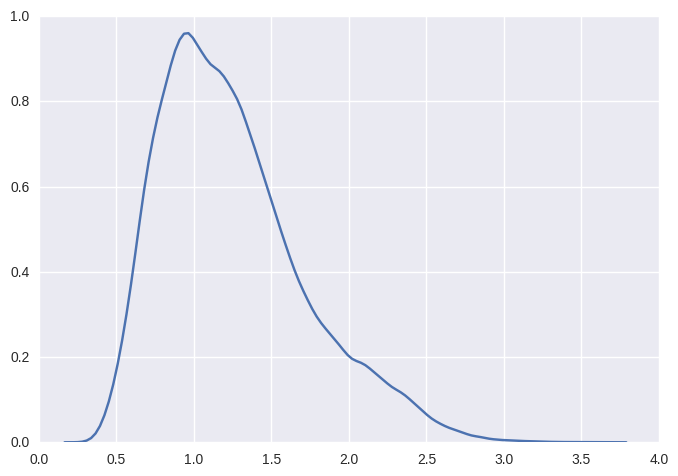

In [79]:
sns.kdeplot(dist)

In [80]:
len(dist)

250000

In [81]:
dist.mean()

1.2477229

In [92]:
a = []
for i in range(499):
    for j in range(i, 500):
        a.append(np.linalg.norm(X_men_cp_polar[i, :] - X_men_cp_polar[j, :]))

In [94]:
b = []
for i in range(499):
    for j in range(i, 500):
        b.append(np.linalg.norm(X_fem_cp_polar[i, :] - X_fem_cp_polar[j, :]))

In [95]:
a = np.array(a)
b = np.array(b)

In [96]:
dist.mean(), a.mean(), b.mean()

(1.2477229, 1.1792151, 1.2829964)

In [99]:
a = []
for i in range(499):
    for j in range(i, 500):
        a.append(np.linalg.norm(X_men_only_polar[i, :] - X_men_only_polar[j, :]))
a = np.array(a)        

In [100]:
b = []
for i in range(499):
    for j in range(i, 500):
        b.append(np.linalg.norm(X_fem_only_polar[i, :] - X_fem_only_polar[j, :]))
b = np.array(b)        

In [101]:
a.mean(), b.mean()

(0.60389608, 0.85484564)

In [103]:
db["MensRights"].find_one()

{u'_id': ObjectId('57c5ddd779a3030ce06585e6'),
 u'archived': True,
 u'author': u'sibqm_lmvm',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u"That event actually happened when I was in sixth grade, way back in the day :)\n\nIm actually studying to be a teacher right now though, and I'd like to be as egalitarian as possible. But I might switch my major to something involving abnormal psych, where I'll have to be extremely non-judging.",
 u'controversiality': 0,
 u'created_utc': datetime.datetime(2012, 4, 30, 20, 0, 15),
 u'date': datetime.datetime(2012, 4, 30, 0, 0),
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c4iiwis',
 u'link_id': u't3_t03pt',
 u'name': u't1_c4iiwis',
 u'parent_id': u't1_c4iiupq',
 u'removal_reason': nan,
 u'retrieved_on': 1428829641,
 u'score': 2,
 u'score_hidden': False,
 u'subreddit': u'MensRights',
 u'subreddit_id': u't5_2qhk3',
 u'tokens': u"that event actually happened when i was in sixth grade , 

In [125]:
db["MensRights"].find_one({"id": "c4iiupq"})

{u'_id': ObjectId('57c5dc6a79a3030ce0657cc8'),
 u'archived': True,
 u'author': u'AryoBarzan',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u"&gt;Yeah... And once you're labeled a misogynist or racist, that person will never think of you any other way. Then again, maybe Georgia is just crazy.\n\nIt CERTAINLY ain't only Georgia, unfortunately.\n\n&gt;I was once told I was going to hell for reading The DaVinci Code, by my fellow sixth grader...\n\nHaha! Well, let me tell you it's quite relieving to hear you're a non-feminist teacher. The education field is where much of this man-hating rhetoric is instilled into young boys and girls. I, unfortunately, experienced much of it growing up.",
 u'controversiality': 0,
 u'created_utc': datetime.datetime(2012, 4, 30, 19, 56, 21),
 u'date': datetime.datetime(2012, 4, 30, 0, 0),
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c4iiupq',
 u'link_id': u't3_t03pt',
 u'name': u't1_c4iiupq',


In [108]:
a = list(db["MensRights"].find({}, {"parent_id": 1, "_id": 0}))
a = map(lambda x: x["parent_id"], a)

In [111]:
a = pd.Series(a)

In [119]:
a.map(lambda x: x.split("_")[0]).value_counts()

t1    1724427
t3     728289
dtype: int64

In [120]:
1724427 + 728289

2452716

In [122]:
b = list(db["Feminism"].find({}, {"parent_id": 1, "_id": 0}))
b = map(lambda x: x["parent_id"], b)

In [123]:
b = pd.Series(b)

In [124]:
b.map(lambda x: x.split("_")[0]).value_counts()

t1    150669
t3     62431
dtype: int64